# Experiments and Preprocessing

In [ ]:
#importing Libraries
import numpy as np
import pandas as pd
from matplotlib.pylab import plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Fake News Detection/WELFake_Dataset.csv')
df

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
...,...,...,...,...
72129,72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


In [ ]:
df.describe()

,Unnamed: 0,label
count,72134.000000,72134.000000
mean,36066.500000,0.514404
std,20823.436496,0.499796
min,0.000000,0.000000
25%,18033.250000,0.000000
50%,36066.500000,1.000000
75%,54099.750000,1.000000
max,72133.000000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [ ]:
y = df.label
print(f'Ratio of real and fake news:')
y.value_counts(normalize=True).rename({1: 'real', 0: 'fake'})

Ratio of real and fake news:


real    0.514404
fake    0.485596
Name: label, dtype: float64

In [ ]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)

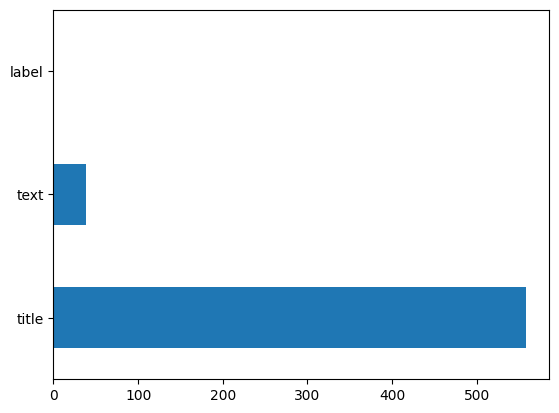

In [ ]:
df.isnull().sum().plot(kind="barh")
plt.show()

In [ ]:
df.isnull().sum()

title    558
text      39
label      0
dtype: int64

In [ ]:
df = df.fillna('')

In [ ]:
df.isnull().sum()

title    0
text     0
label    0
dtype: int64

In [ ]:
df.nunique()

title    62348
text     62719
label        2
dtype: int64

In [ ]:
df["title_text"] = df["title"] + df["text"]
df["body_len"] = df["title_text"].apply(lambda x: len(x) - x.count(" "))
df.head()

,title,text,label,title_text,body_len
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,4222
1,,Did they post their votes for Hillary already?,1,Did they post their votes for Hillary already?,39
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,299
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri...",6811
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...,1668


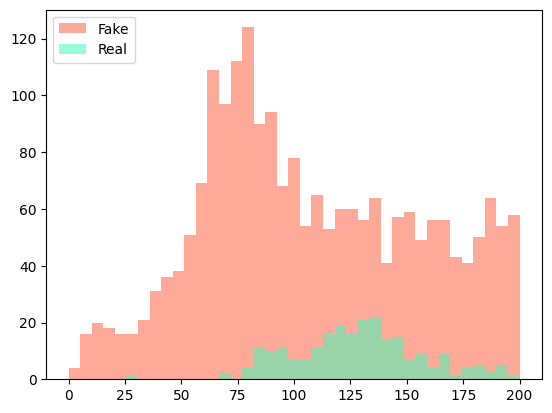

In [ ]:
bins = np.linspace(0, 200, 40)

plt.hist(df[df["label"]== 1]["body_len"], bins, alpha=0.5, label="Fake", color="#FF5733")
plt.hist(df[df["label"]== 0]["body_len"], bins, alpha=0.5, label="Real", color="#33FFB8")
plt.legend(loc="upper left")
plt.show()

Text(0.5, 1.0, 'Distribution of Fake/Real News')

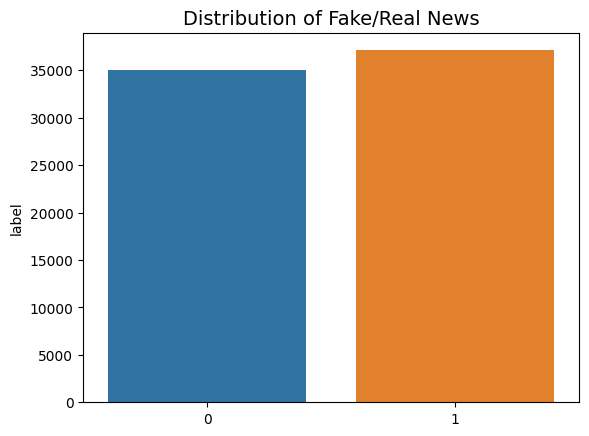

In [ ]:
class_names = ['fake', 'real']
label_count = df.label.value_counts()
sns.barplot(x=label_count.index, y=label_count)
plt.title('Distribution of Fake/Real News',fontsize =14)

In [ ]:
#Preprocessing
# Function to preprocess text
def preprocess_text(text):
    if isinstance(text, str):
        # Remove URLs
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Remove Unicode characters
        text = text.encode('ascii', 'ignore').decode()
        # Convert to lowercase
        text = text.lower()
        return text
    else:
        return ''

# Apply preprocessing to each row in the 'text' column
df['cleaned_text'] = df['text'].apply(preprocess_text)
df

,title,text,label,title_text,body_len,cleaned_text
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,4222,no comment is expected from barack obama membe...
1,,Did they post their votes for Hillary already?,1,Did they post their votes for Hillary already?,39,did they post their votes for hillary already
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,299,now most of the demonstrators gathered last n...
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri...",6811,a dozen politically active pastors came here f...
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...,1668,the rs sarmat missile dubbed satan will repla...
...,...,...,...,...,...,...
72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0,Russians steal research on Trump in hack of U....,4098,washington reuters hackers believed to be wor...
72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1,WATCH: Giuliani Demands That Democrats Apolog...,3092,you know because in fantasyland republicans ne...
72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0,Migrants Refuse To Leave Train At Refugee Camp...,2447,migrants refuse to leave train at refugee camp...
72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0,Trump tussle gives unpopular Mexican leader mu...,2868,mexico city reuters donald trumps combative s...


In [ ]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

df = df.dropna(subset=['text'])

# Initialize stopwords
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenize the text into words
    words = nltk.word_tokenize(text)

    # Remove punctuation and convert to lowercase
    words = [word.lower() for word in words if word.isalpha()]

    # Remove stopwords
    words = [word for word in words if word not in stop_words]

    # Join the words back into a sentence
    return ' '.join(words)

# Apply preprocessing and store the result in a new column 'processed_text'
df['processed_text'] = df['cleaned_text'].apply(preprocess_text)

df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,title,text,label,title_text,body_len,cleaned_text,processed_text
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,4222,no comment is expected from barack obama membe...,comment expected barack obama members fyf fuky...
1,,Did they post their votes for Hillary already?,1,Did they post their votes for Hillary already?,39,did they post their votes for hillary already,post votes hillary already
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,299,now most of the demonstrators gathered last n...,demonstrators gathered last night exercising c...
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri...",6811,a dozen politically active pastors came here f...,dozen politically active pastors came private ...
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...,1668,the rs sarmat missile dubbed satan will repla...,rs sarmat missile dubbed satan replace ss flie...
...,...,...,...,...,...,...,...
72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0,Russians steal research on Trump in hack of U....,4098,washington reuters hackers believed to be wor...,washington reuters hackers believed working ru...
72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1,WATCH: Giuliani Demands That Democrats Apolog...,3092,you know because in fantasyland republicans ne...,know fantasyland republicans never questioned ...
72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0,Migrants Refuse To Leave Train At Refugee Camp...,2447,migrants refuse to leave train at refugee camp...,migrants refuse leave train refugee camp hunga...
72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0,Trump tussle gives unpopular Mexican leader mu...,2868,mexico city reuters donald trumps combative s...,mexico city reuters donald trumps combative st...


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], y, test_size=0.1, random_state=42)

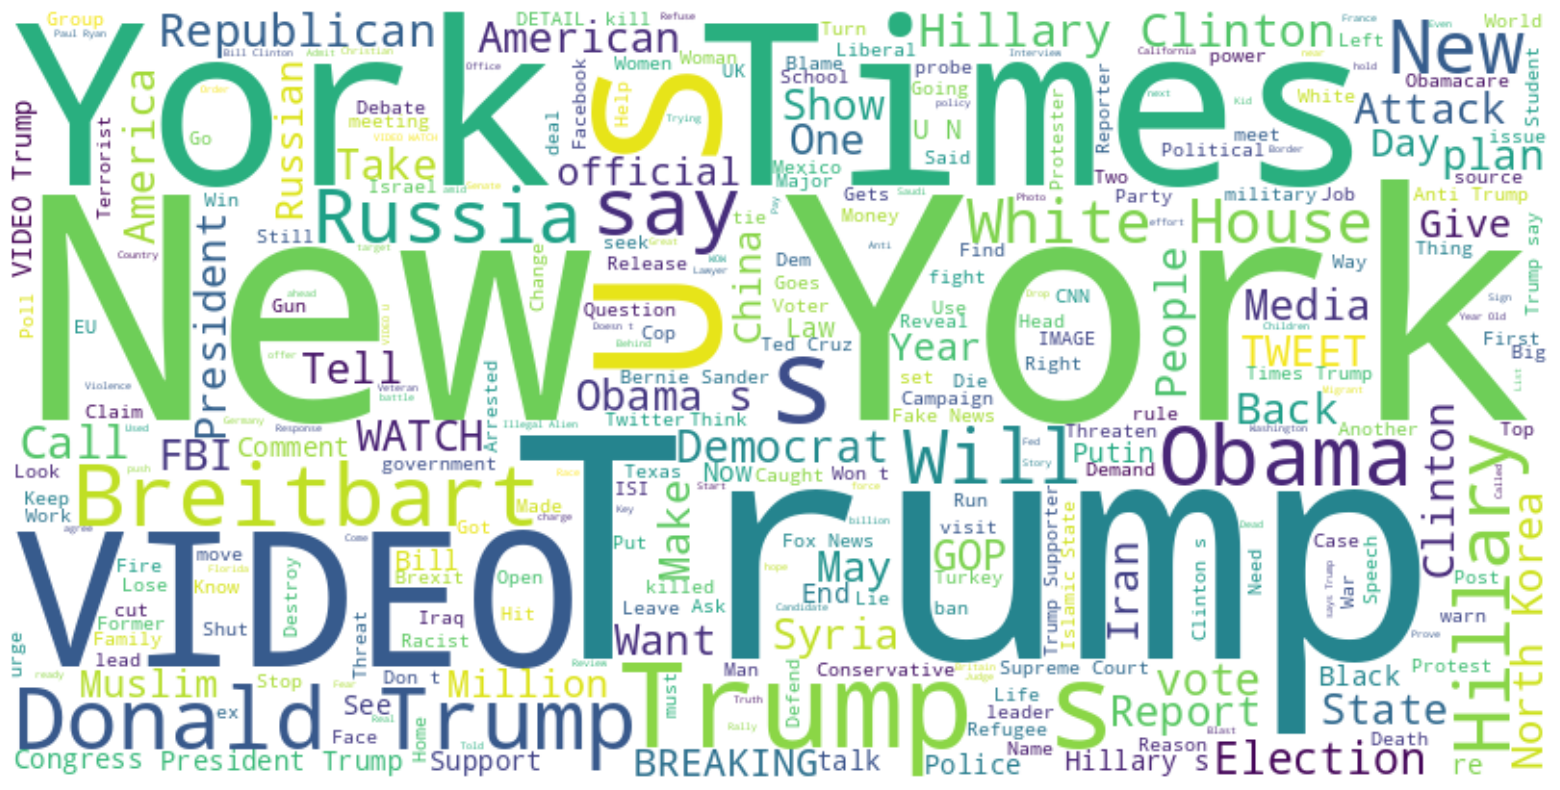

In [ ]:
titles = ' '.join(title for title in df['title'])
wordcloud = WordCloud(
    background_color='white',
    max_words=300,
    width=800,
    height=400,
).generate(titles)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

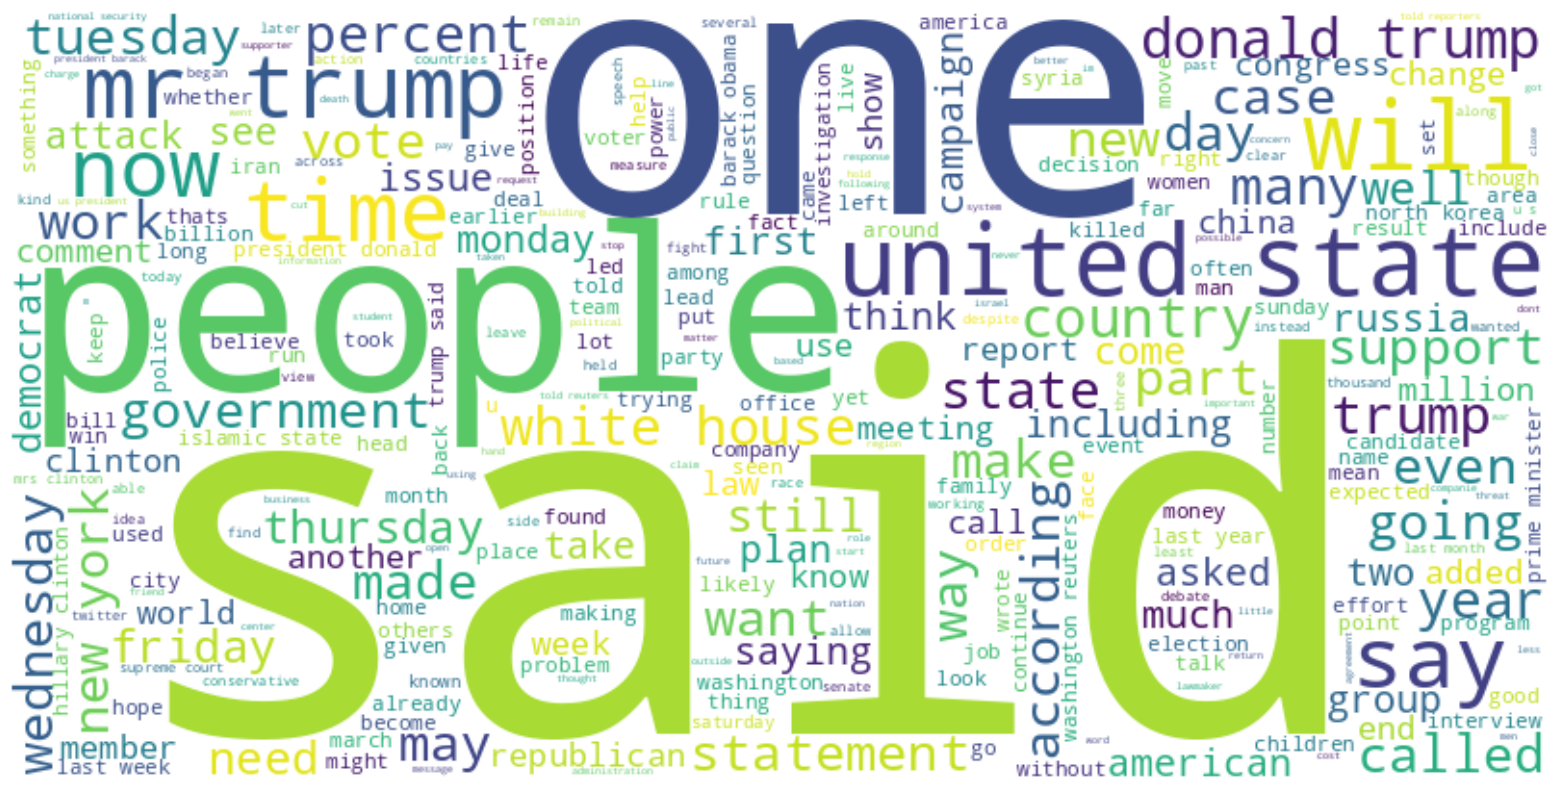

In [ ]:
fake_news = X_train[y_train == 0]
real_news = X_train[y_train == 1]
fake_texts = ' '.join(text for text in fake_news)
wordcloud = WordCloud(
    background_color='white',
    max_words=300,
    width=800,
    height=400,
).generate(fake_texts)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

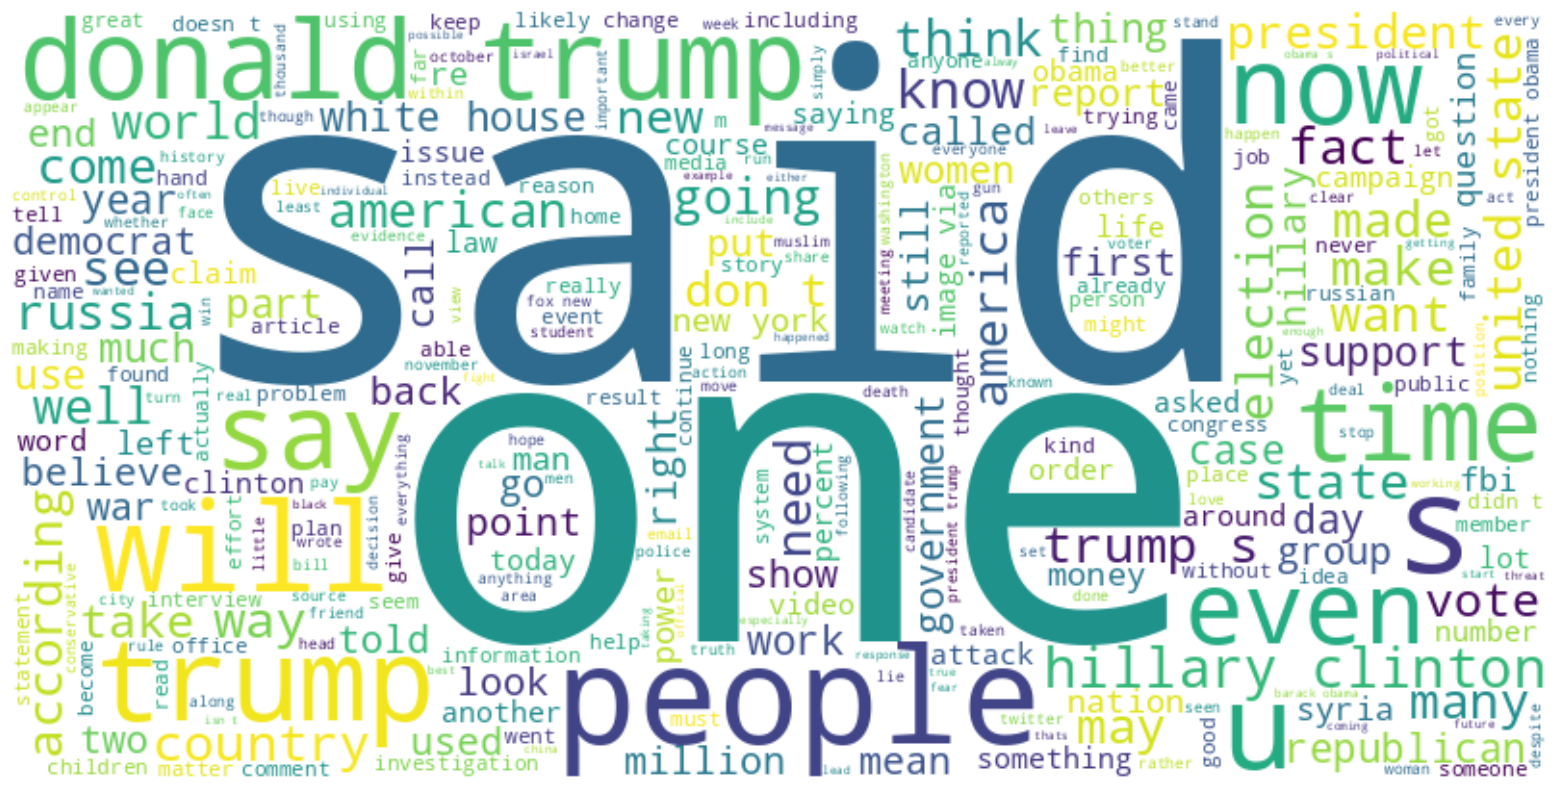

In [ ]:
real_texts = ' '.join(text for text in real_news)
wordcloud = WordCloud(
    background_color='white',
    max_words=300,
    width=800,
    height=400,
).generate(real_texts)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show

# Model

In [ ]:
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.7, ngram_range=(1, 1), max_features=15000)

In [ ]:
# Transform the training and testing data into TF-IDF features
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [ ]:
max_sequence_length = 100
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post')

## CNN

In [ ]:
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_sequence_length))
cnn_model.add(Conv1D(128, 5, activation='relu'))  # 128 filters with window size 5
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
cnn = cnn_model.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_data=(X_test_padded, y_test), verbose=1)

Epoch 1/5
1015/1015 [==============================] - 37s 36ms/step - loss: 0.2505 - accuracy: 0.8933 - val_loss: 0.1828 - val_accuracy: 0.9246
Epoch 2/5
1015/1015 [==============================] - 19s 19ms/step - loss: 0.1200 - accuracy: 0.9560 - val_loss: 0.1521 - val_accuracy: 0.9426
Epoch 3/5
1015/1015 [==============================] - 16s 16ms/step - loss: 0.0501 - accuracy: 0.9848 - val_loss: 0.1584 - val_accuracy: 0.9458
Epoch 4/5
1015/1015 [==============================] - 16s 16ms/step - loss: 0.0152 - accuracy: 0.9972 - val_loss: 0.1857 - val_accuracy: 0.9462
Epoch 5/5
1015/1015 [==============================] - 15s 15ms/step - loss: 0.0051 - accuracy: 0.9994 - val_loss: 0.2136 - val_accuracy: 0.9457


In [ ]:
loss, accuracy = cnn_model.evaluate(X_test_padded, y_test)
print("Accuracy:", accuracy)

226/226 [==============================] - 1s 3ms/step - loss: 0.2136 - accuracy: 0.9457
Accuracy: 0.945661187171936


In [ ]:
pred = cnn_model.predict(X_test_padded)
pred_labels = (pred > 0.5).astype(int)

226/226 [==============================] - 0s 2ms/step


In [ ]:
print(classification_report(y_test, pred_labels))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      3534
           1       0.94      0.95      0.95      3680

    accuracy                           0.95      7214
   macro avg       0.95      0.95      0.95      7214
weighted avg       0.95      0.95      0.95      7214



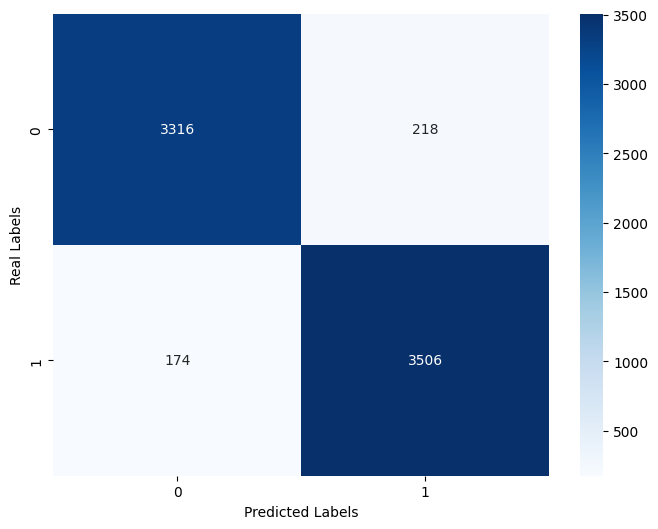

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, pred_labels), annot=True, fmt='', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')
plt.show()

## LSTM

In [ ]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_sequence_length))
lstm_model.add(LSTM(128))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train the LSTM model
lstm = lstm_model.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_data=(X_test_padded, y_test), verbose=1)

Epoch 1/5
1015/1015 [==============================] - 44s 40ms/step - loss: 0.2890 - accuracy: 0.8825 - val_loss: 0.2917 - val_accuracy: 0.8827
Epoch 2/5
1015/1015 [==============================] - 21s 21ms/step - loss: 0.2199 - accuracy: 0.9151 - val_loss: 0.2898 - val_accuracy: 0.8818
Epoch 3/5
1015/1015 [==============================] - 20s 19ms/step - loss: 0.1604 - accuracy: 0.9394 - val_loss: 0.1722 - val_accuracy: 0.9335
Epoch 4/5
1015/1015 [==============================] - 19s 19ms/step - loss: 0.1139 - accuracy: 0.9596 - val_loss: 0.1951 - val_accuracy: 0.9246
Epoch 5/5
1015/1015 [==============================] - 19s 19ms/step - loss: 0.0900 - accuracy: 0.9688 - val_loss: 0.1796 - val_accuracy: 0.9400


In [ ]:
# Evaluate the model on test data
loss, accuracy = lstm_model.evaluate(X_test_padded, y_test)
print("Accuracy:", accuracy)

226/226 [==============================] - 1s 5ms/step - loss: 0.1796 - accuracy: 0.9400
Accuracy: 0.9399778246879578


In [ ]:
# Make predictions on the test set
pred = lstm_model.predict(X_test_padded)
pred_labels = (pred > 0.5).astype(int)

226/226 [==============================] - 1s 3ms/step


In [ ]:
# Print classification report
print(classification_report(y_test, pred_labels))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      3534
           1       0.95      0.93      0.94      3680

    accuracy                           0.94      7214
   macro avg       0.94      0.94      0.94      7214
weighted avg       0.94      0.94      0.94      7214



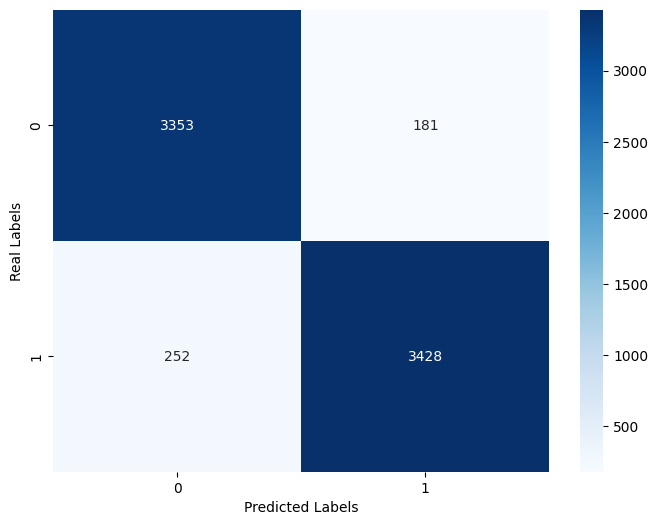

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, pred_labels), annot=True, fmt='', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')
plt.show()

## GRU

In [ ]:
from tensorflow.keras.layers import GRU

gru_model = Sequential()
gru_model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_sequence_length))
gru_model.add(GRU(128))
gru_model.add(Dense(1, activation='sigmoid'))

# Compile the model
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
gru = gru_model.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_data=(X_test_padded, y_test), verbose=1)

Epoch 1/5
1015/1015 [==============================] - 42s 38ms/step - loss: 0.2436 - accuracy: 0.8999 - val_loss: 0.1837 - val_accuracy: 0.9292
Epoch 2/5
1015/1015 [==============================] - 21s 21ms/step - loss: 0.1448 - accuracy: 0.9457 - val_loss: 0.1639 - val_accuracy: 0.9342
Epoch 3/5
1015/1015 [==============================] - 19s 19ms/step - loss: 0.1058 - accuracy: 0.9621 - val_loss: 0.1759 - val_accuracy: 0.9330
Epoch 4/5
1015/1015 [==============================] - 20s 19ms/step - loss: 0.0768 - accuracy: 0.9733 - val_loss: 0.1695 - val_accuracy: 0.9407
Epoch 5/5
1015/1015 [==============================] - 18s 18ms/step - loss: 0.0524 - accuracy: 0.9822 - val_loss: 0.1938 - val_accuracy: 0.9408


In [ ]:
loss, accuracy = gru_model.evaluate(X_test_padded, y_test)
print("Accuracy:", accuracy)

226/226 [==============================] - 1s 4ms/step - loss: 0.1938 - accuracy: 0.9408
Accuracy: 0.9408095479011536


In [ ]:
pred = gru_model.predict(X_test_padded)
pred_labels = (pred > 0.5).astype(int)

226/226 [==============================] - 1s 3ms/step


In [ ]:
print(classification_report(y_test, pred_labels))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      3534
           1       0.93      0.95      0.94      3680

    accuracy                           0.94      7214
   macro avg       0.94      0.94      0.94      7214
weighted avg       0.94      0.94      0.94      7214



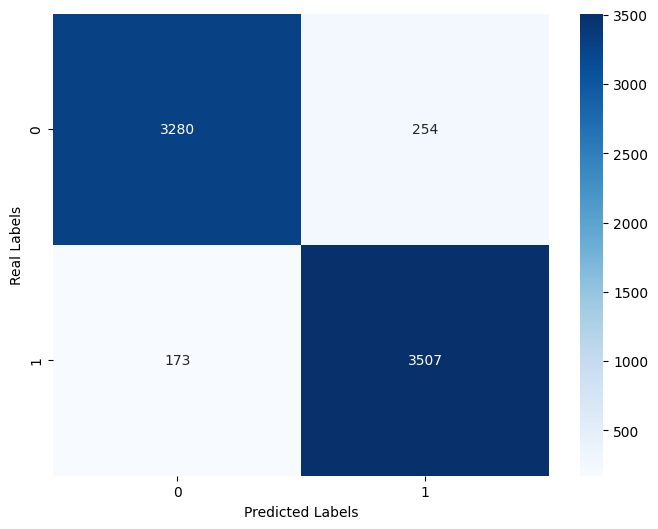

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, pred_labels), annot=True, fmt='', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')
plt.show()

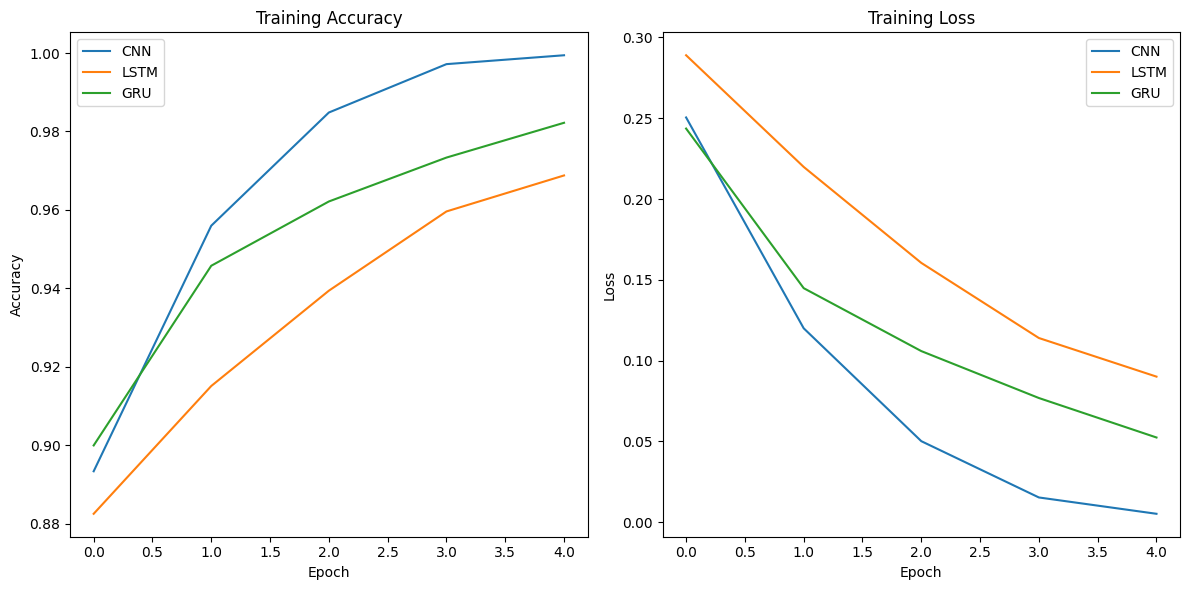

In [ ]:
# Plotting accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cnn.history['accuracy'], label='CNN')
plt.plot(lstm.history['accuracy'], label='LSTM')
plt.plot(gru.history['accuracy'], label='GRU')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(cnn.history['loss'], label='CNN')
plt.plot(lstm.history['loss'], label='LSTM')
plt.plot(gru.history['loss'], label='GRU')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()